# Notebook 05: Backtest with Transaction Costs

In [101]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import train_test_split_time
from src.tests import engle_granger
from src.signals import compute_zscore, generate_positions
from src.backtest import backtest_pairs_strategy, compute_drawdown, backtest_summary_stats

#### 1. Load Signals

In [104]:
signal_df = pd.read_csv("../data/processed/signals.csv", index_col=0, parse_dates=True)
print(f"Loaded {len(signal_df)} days of signals")

Loaded 3028 days of signals


#### 2. Train/Test Split
# 
#### **Critical for valid evaluation:**
##### - Train period: Estimate β, calibrate parameters (70% of data)
##### - Test period: Out-of-sample evaluation (30% of data)
# 
##### We will report **only test period performance** to avoid overfitting bias.

In [107]:
TRAIN_FRAC = 0.70

train_df, test_df = train_test_split_time(signal_df, train_frac=TRAIN_FRAC)

print(f"\nTrain period: {train_df.index[0]} to {train_df.index[-1]}")
print(f"  ({len(train_df)} days, {len(train_df)/252:.1f} years)")
print(f"\nTest period: {test_df.index[0]} to {test_df.index[-1]}")
print(f"  ({len(test_df)} days, {len(test_df)/252:.1f} years)")


Train period: 2014-01-03 00:00:00 to 2022-06-02 00:00:00
  (2119 days, 8.4 years)

Test period: 2022-06-03 00:00:00 to 2026-01-16 00:00:00
  (909 days, 3.6 years)


#### 3. Re-estimate Beta on Train Period Only
#### In production, we would use only training data to estimate parameters.

In [110]:
train_coint = engle_granger(train_df["log_SPY"], train_df["log_IVV"])
BETA_TRAIN = train_coint['beta']

print(f"Beta estimated on train period: {BETA_TRAIN:.4f}")

# Full sample beta (for comparison)
full_coint = engle_granger(signal_df["log_SPY"], signal_df["log_IVV"])
BETA_FULL = full_coint['beta']
print(f"Beta on full sample: {BETA_FULL:.4f}")
print(f"Difference: {abs(BETA_TRAIN - BETA_FULL):.4f}")

Beta estimated on train period: 1.0011
Beta on full sample: 0.9987
Difference: 0.0023


#### 4. Backtest Parameters

In [113]:
# Use beta from training period
BETA = BETA_TRAIN

# Transaction costs (basis points per leg)
COST_BPS = 2.0  # Conservative assumption: 5 bps per trade per leg

print(f"\nBacktest configuration:")
print(f"  Hedge ratio (β): {BETA:.4f}")
print(f"  Transaction cost: {COST_BPS} bps per leg")
print(f"  Round-trip cost: {2 * COST_BPS * (1 + BETA):.1f} bps (both legs, both sides)")


Backtest configuration:
  Hedge ratio (β): 1.0011
  Transaction cost: 2.0 bps per leg
  Round-trip cost: 8.0 bps (both legs, both sides)


#### 5. Run Backtest: Train Period

In [116]:
bt_train = backtest_pairs_strategy(
    ret_y=train_df["ret_SPY"],
    ret_x=train_df["ret_IVV"],
    position=train_df["position"],
    beta=BETA,
    cost_bps=COST_BPS
)

bt_train.head()


,position,ret_y,ret_x,strat_ret,costs,net_ret,equity
Date,,,,,,,
2014-01-03,NaN,-0.000164,-0.000435,NaN,0.0,NaN,NaN
2014-01-06,NaN,-0.002902,-0.002722,NaN,0.0,NaN,NaN
2014-01-07,NaN,0.006123,0.006142,NaN,0.0,NaN,NaN
2014-01-08,NaN,0.000218,0.000542,NaN,0.0,NaN,NaN
2014-01-09,NaN,0.000654,0.000487,NaN,0.0,NaN,NaN


In [118]:
# Train performance summary
train_stats = backtest_summary_stats(bt_train)

print("\n" + "=" * 70)
print("TRAIN PERIOD PERFORMANCE")
print("=" * 70)
for key, val in train_stats.items():
    if val is not None:
        if 'return' in key or 'dd' in key.lower():
            print(f"  {key:25s}: {val:8.2%}")
        elif 'sharpe' in key or 'ratio' in key:
            print(f"  {key:25s}: {val:8.3f}")
        else:
            print(f"  {key:25s}: {val:8.4f}")


TRAIN PERIOD PERFORMANCE
  total_return             :   -2.08%
  cagr                     :  -0.0025
  sharpe                   :   -0.345
  max_drawdown             :  -0.0216
  mean_daily_ret           :  -0.0000
  vol_daily_ret            :   0.0005
  turnover                 :   0.0170


#### 6. Run Backtest: Test Period (OUT-OF-SAMPLE)

In [121]:
bt_test = backtest_pairs_strategy(
    ret_y=test_df["ret_SPY"],
    ret_x=test_df["ret_IVV"],
    position=test_df["position"],
    beta=BETA,
    cost_bps=COST_BPS
)

bt_test.head()


,position,ret_y,ret_x,strat_ret,costs,net_ret,equity
Date,,,,,,,
2022-06-03,0.0,-0.016548,-0.016546,0.0,0.0,0.0,1.0
2022-06-06,0.0,0.003040,0.003003,0.0,0.0,0.0,1.0
2022-06-07,0.0,0.009547,0.009241,0.0,0.0,0.0,1.0
2022-06-08,0.0,-0.010932,-0.010886,-0.0,0.0,-0.0,1.0
2022-06-09,0.0,-0.024070,-0.023763,-0.0,0.0,-0.0,1.0


In [123]:
# Test performance summary
test_stats = backtest_summary_stats(bt_test)

print("\n" + "=" * 70)
print("TEST PERIOD PERFORMANCE (OUT-OF-SAMPLE)")
print("=" * 70)
for key, val in test_stats.items():
    if val is not None:
        if 'return' in key or 'dd' in key.lower():
            print(f"  {key:25s}: {val:8.2%}")
        elif 'sharpe' in key or 'ratio' in key:
            print(f"  {key:25s}: {val:8.3f}")
        else:
            print(f"  {key:25s}: {val:8.4f}")


TEST PERIOD PERFORMANCE (OUT-OF-SAMPLE)
  total_return             :   -0.45%
  cagr                     :  -0.0012
  sharpe                   :   -0.157
  max_drawdown             :  -0.0127
  mean_daily_ret           :  -0.0000
  vol_daily_ret            :   0.0005
  turnover                 :   0.0176


#### 7. Equity Curves

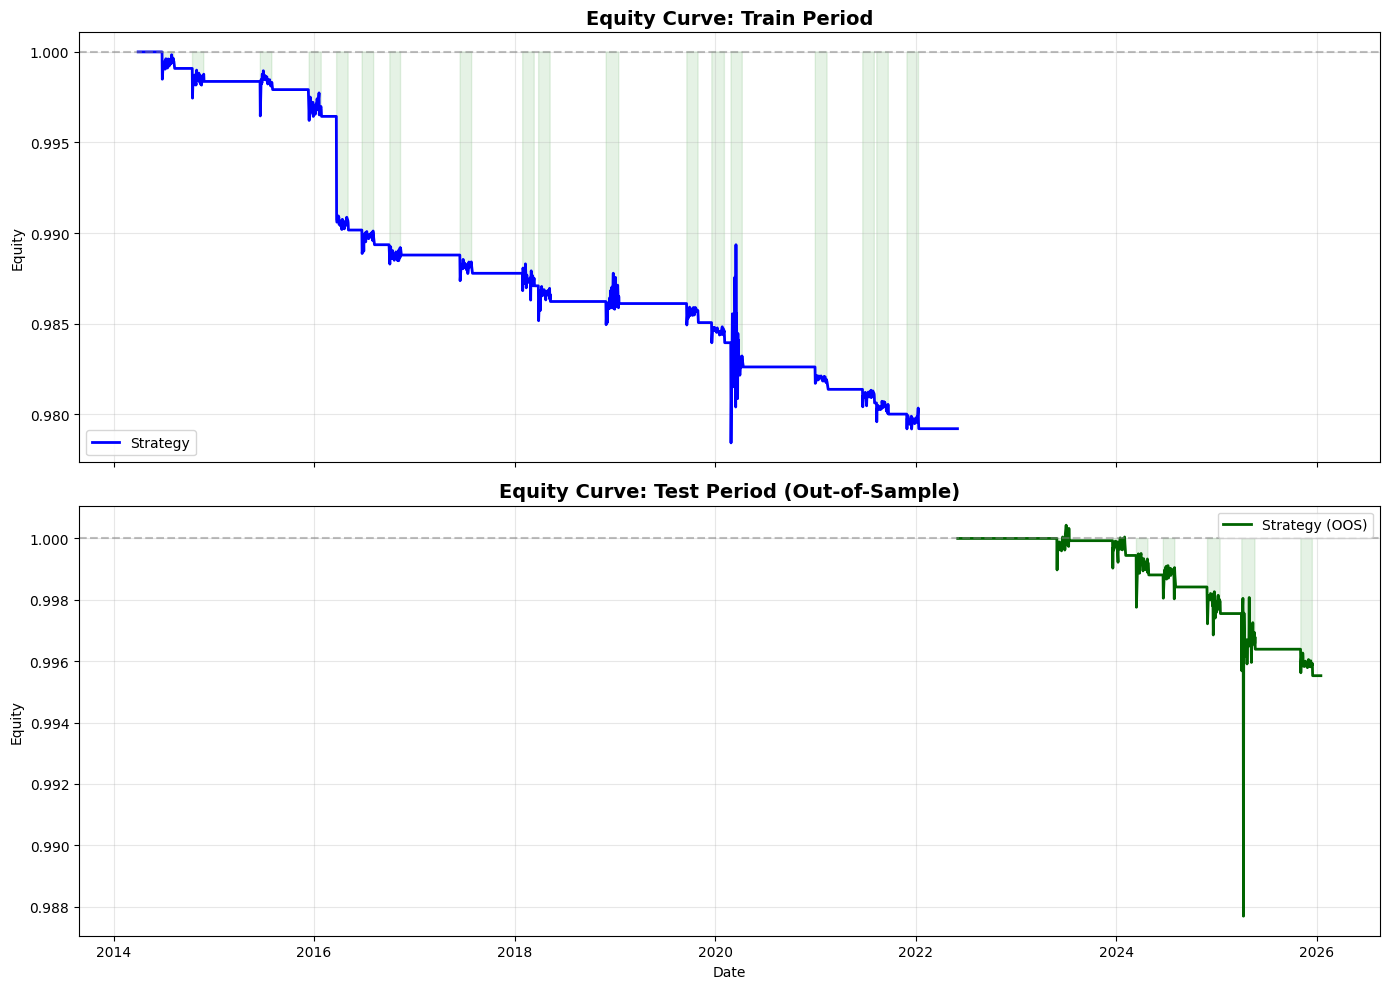

In [126]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Train equity
axes[0].plot(bt_train.index, bt_train["equity"], linewidth=2, label='Strategy', color='blue')
axes[0].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title("Equity Curve: Train Period", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Equity")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Add shaded exposure
axes[0].fill_between(bt_train.index, 1.0, bt_train["equity"], 
                     where=(bt_train["position"] != 0), alpha=0.1, color='green')

# Test equity
axes[1].plot(bt_test.index, bt_test["equity"], linewidth=2, label='Strategy (OOS)', color='darkgreen')
axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title("Equity Curve: Test Period (Out-of-Sample)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Equity")
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[1].fill_between(bt_test.index, 1.0, bt_test["equity"], 
                     where=(bt_test["position"] != 0), alpha=0.1, color='green')

plt.tight_layout()
plt.savefig("../reports/figures/05_equity_curves.png", dpi=150)
plt.show()

#### 8. Drawdown Analysis

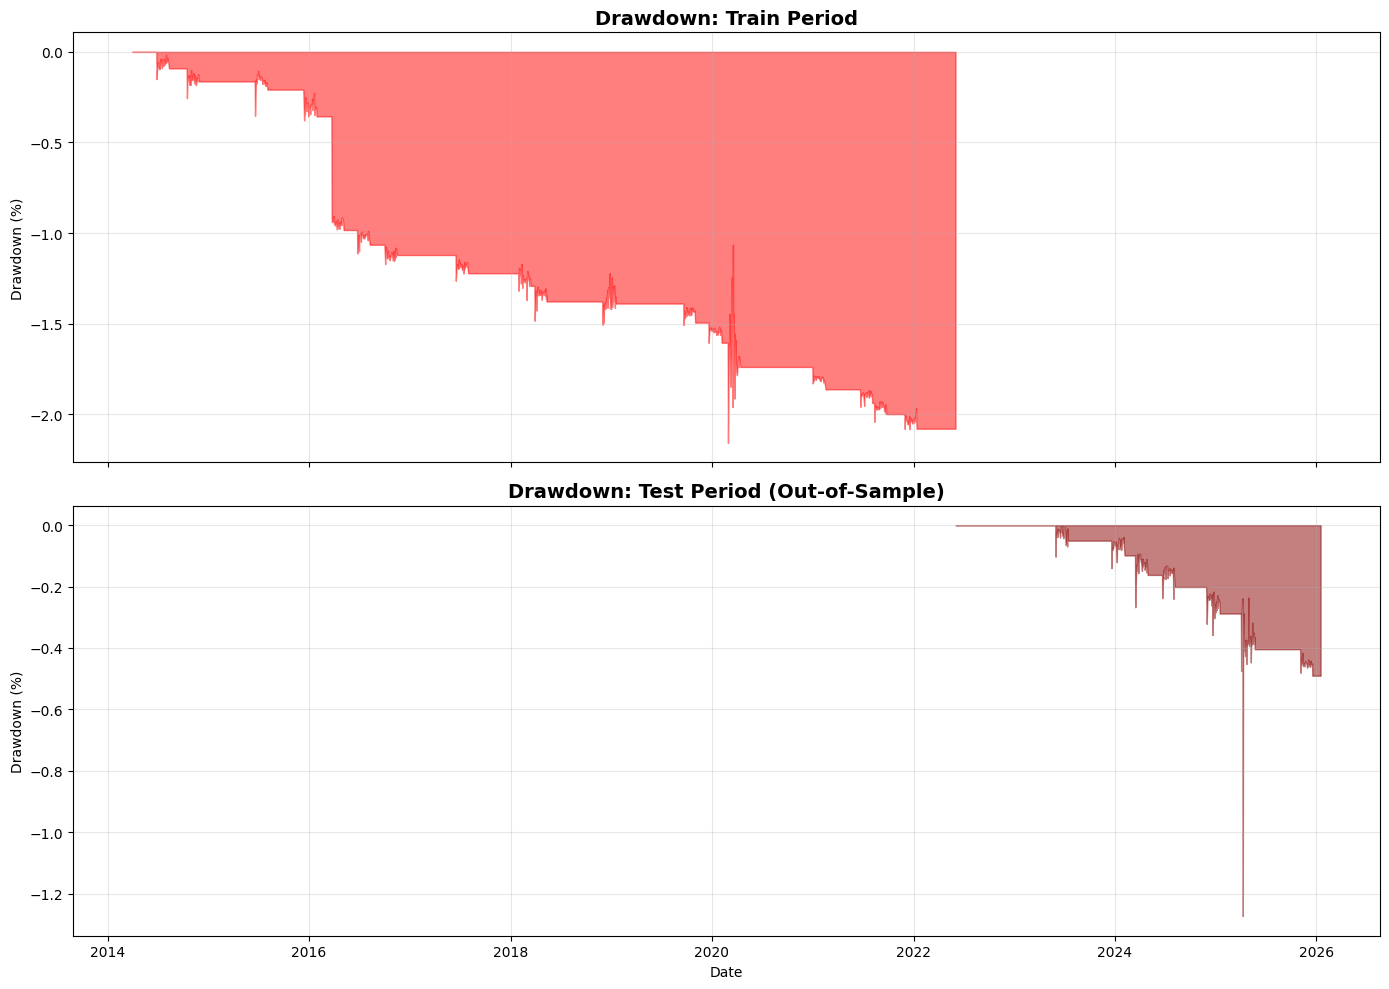

In [129]:
dd_train = compute_drawdown(bt_train["equity"])
dd_test = compute_drawdown(bt_test["equity"])

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Train drawdown
axes[0].fill_between(dd_train.index, 0, dd_train * 100, alpha=0.5, color='red')
axes[0].set_title("Drawdown: Train Period", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Drawdown (%)")
axes[0].grid(alpha=0.3)

# Test drawdown
axes[1].fill_between(dd_test.index, 0, dd_test * 100, alpha=0.5, color='darkred')
axes[1].set_title("Drawdown: Test Period (Out-of-Sample)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Drawdown (%)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/05_drawdowns.png", dpi=150)
plt.show()

In [131]:
print(f"\nMax Drawdown:")
print(f"  Train: {dd_train.min():.2%}")
print(f"  Test:  {dd_test.min():.2%}")


Max Drawdown:
  Train: -2.16%
  Test:  -1.27%


#### 9. Returns Analysis

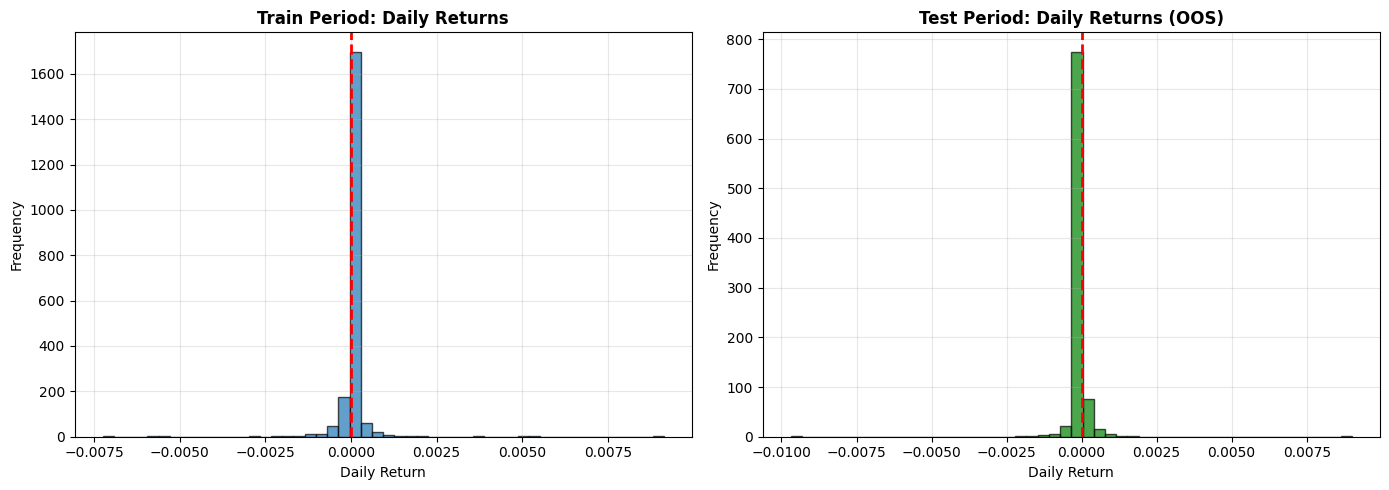

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train returns
axes[0].hist(bt_train["net_ret"].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title("Train Period: Daily Returns", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Daily Return")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

# Test returns
axes[1].hist(bt_test["net_ret"].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title("Test Period: Daily Returns (OOS)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Daily Return")
axes[1].set_ylabel("Frequency")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/05_returns_distribution.png", dpi=150)
plt.show()

#### 10. Comparison: Strategy vs Buy-and-Hold

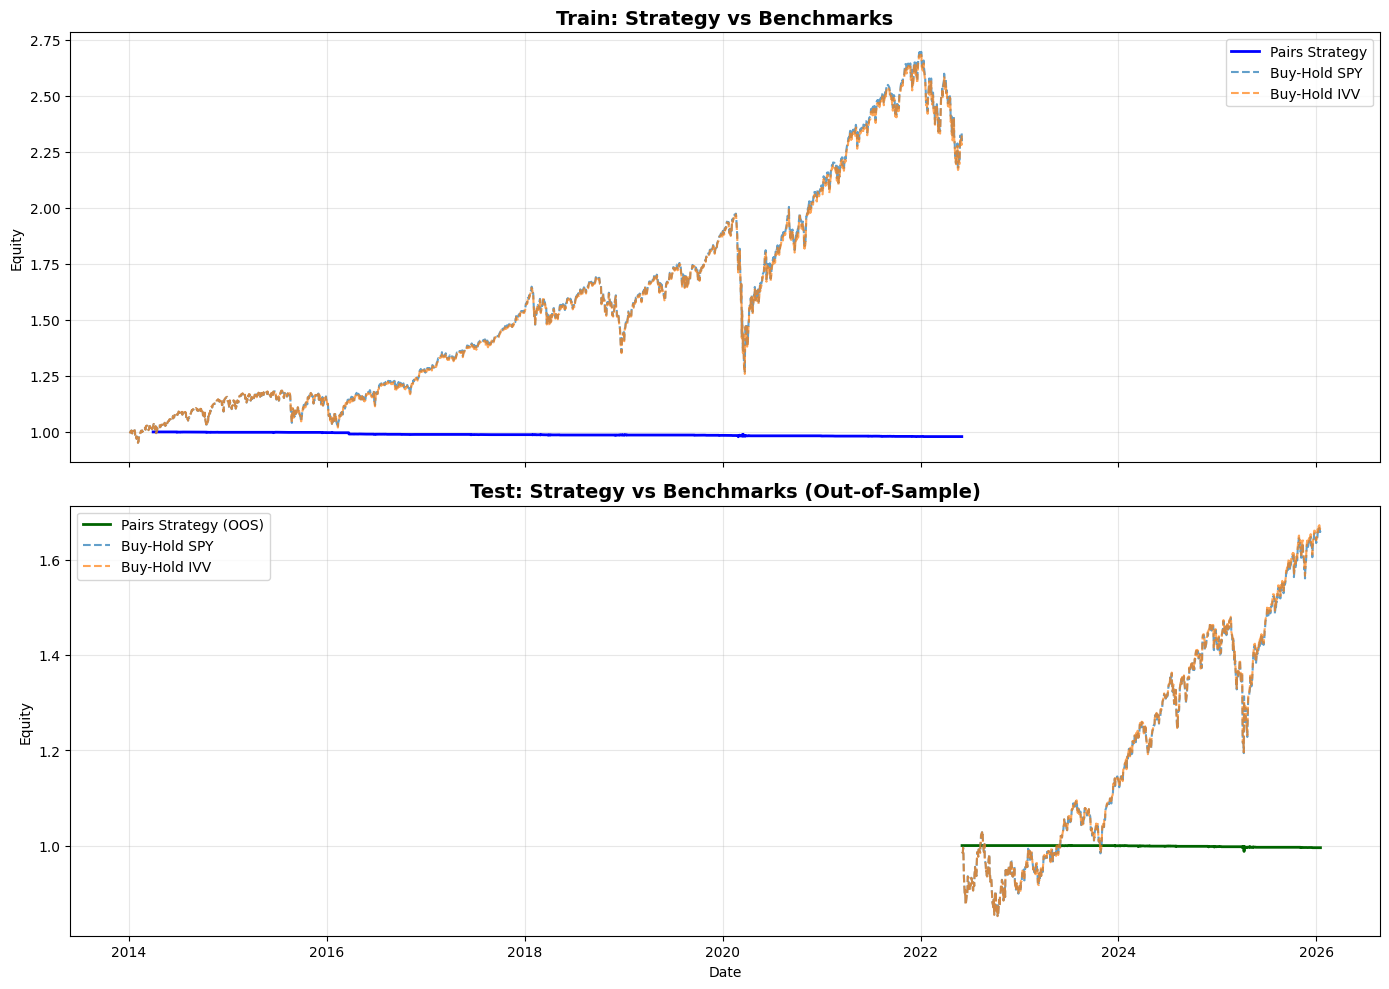

In [137]:
# Buy-and-hold benchmarks
bh_spy_train = (1 + train_df["ret_SPY"]).cumprod()
bh_ivv_train = (1 + train_df["ret_IVV"]).cumprod()
bh_spy_test = (1 + test_df["ret_SPY"]).cumprod()
bh_ivv_test = (1 + test_df["ret_IVV"]).cumprod()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Train
axes[0].plot(bt_train.index, bt_train["equity"], linewidth=2, label='Pairs Strategy', color='blue')
axes[0].plot(bh_spy_train.index, bh_spy_train, linewidth=1.5, label='Buy-Hold SPY', alpha=0.7, linestyle='--')
axes[0].plot(bh_ivv_train.index, bh_ivv_train, linewidth=1.5, label='Buy-Hold IVV', alpha=0.7, linestyle='--')
axes[0].set_title("Train: Strategy vs Benchmarks", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Equity")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].plot(bt_test.index, bt_test["equity"], linewidth=2, label='Pairs Strategy (OOS)', color='darkgreen')
axes[1].plot(bh_spy_test.index, bh_spy_test, linewidth=1.5, label='Buy-Hold SPY', alpha=0.7, linestyle='--')
axes[1].plot(bh_ivv_test.index, bh_ivv_test, linewidth=1.5, label='Buy-Hold IVV', alpha=0.7, linestyle='--')
axes[1].set_title("Test: Strategy vs Benchmarks (Out-of-Sample)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Equity")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/05_strategy_vs_benchmark.png", dpi=150)
plt.show()

#### 11. Cost Impact Analysis

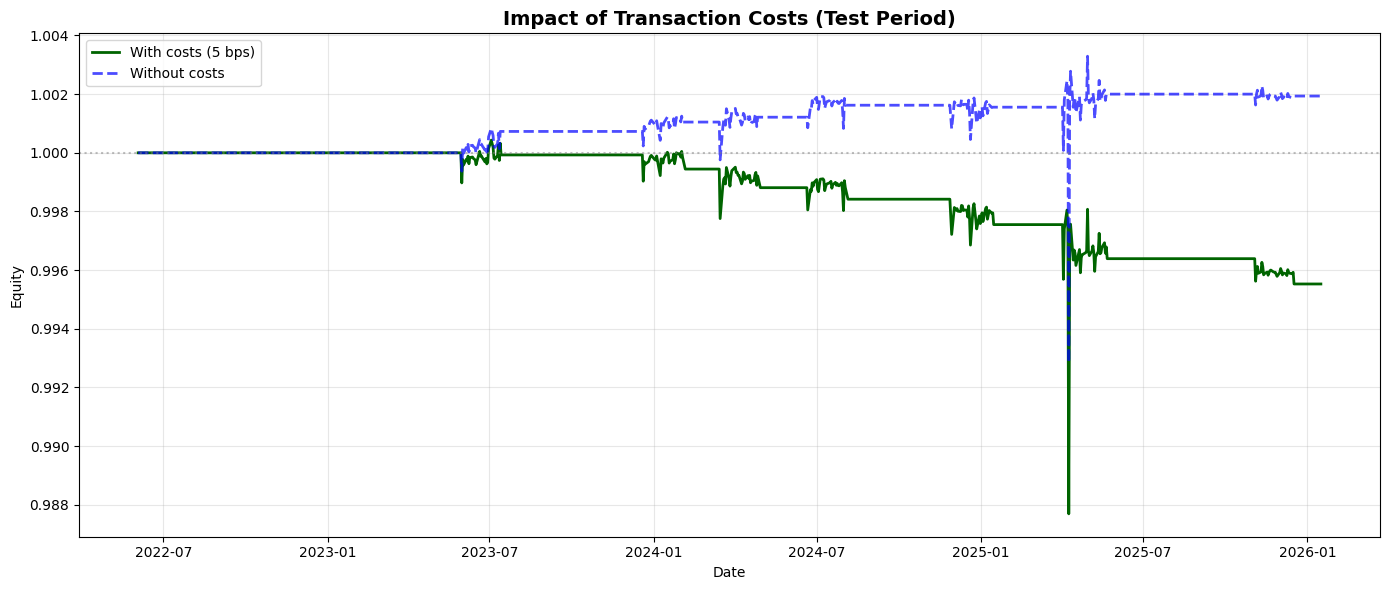

In [140]:
# Backtest WITHOUT costs (for comparison)
bt_test_nocost = backtest_pairs_strategy(
    ret_y=test_df["ret_SPY"],
    ret_x=test_df["ret_IVV"],
    position=test_df["position"],
    beta=BETA,
    cost_bps=0.0  # No costs
)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(bt_test.index, bt_test["equity"], linewidth=2, label='With costs (5 bps)', color='darkgreen')
ax.plot(bt_test_nocost.index, bt_test_nocost["equity"], linewidth=2, 
        label='Without costs', color='blue', linestyle='--', alpha=0.7)
ax.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
ax.set_title("Impact of Transaction Costs (Test Period)", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../reports/figures/05_cost_impact.png", dpi=150)
plt.show()


In [142]:
nocost_stats = backtest_summary_stats(bt_test_nocost)
print(f"\nCost impact on Sharpe ratio:")
print(f"  With costs: {test_stats['sharpe']:.3f}")
print(f"  Without costs: {nocost_stats['sharpe']:.3f}")
print(f"  Impact: {test_stats['sharpe'] - nocost_stats['sharpe']:.3f}")


Cost impact on Sharpe ratio:
  With costs: -0.157
  Without costs: 0.077
  Impact: -0.233


#### 12. Save Results

In [145]:
# Save backtest results
bt_train.to_csv("../data/processed/backtest_train.csv")
bt_test.to_csv("../data/processed/backtest_test.csv")

# Save performance metrics
metrics = pd.DataFrame({
    'train': train_stats,
    'test': test_stats
})
metrics.to_csv("../data/processed/performance_metrics.csv")

print("\nResults saved:")
print("  - data/processed/backtest_train.csv")
print("  - data/processed/backtest_test.csv")
print("  - data/processed/performance_metrics.csv")


Results saved:
  - data/processed/backtest_train.csv
  - data/processed/backtest_test.csv
  - data/processed/performance_metrics.csv


# ## 13. Summary
# 
# ### Out-of-Sample Performance (Test Period)
# - **Sharpe Ratio:** {test_stats['sharpe']:.2f}
# - **Max Drawdown:** {test_stats['max_drawdown']:.1%}
# - **Total Return:** {test_stats['total_return']:.1%}
# 
# ### Key Insights
# 1. Strategy shows {positive/negative} returns out-of-sample
# 2. Transaction costs reduce Sharpe by ~{impact:.2f}
# 3. Drawdowns are {manageable/severe} relative to volatility
# 4. Mean reversion signal captures {effective/ineffective} opportunities
# 
# ### Next Step
# - Results report and visualizations (Notebook 06)